In [1]:
from project.models.char_baseline import CharSeqBaseline
from project.models.code2vec_solo import Code2VecSolo
from project.models.code2vec_encoder import Code2VecEncoder
from project.models.base_model import _run_model


/home/ehambro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
load_dir = {"logdir":"logs/BIG_X_new_attention_second_experiment__var_otherargs_2008_102707/best_bleu", "mode":"RETURN"}
LOADED = _run_model(CharSeqBaseline, **load_dir)


LOADING FROM: logs/BIG_X_new_attention_second_experiment__var_otherargs_2008_102707/best_bleu, overwriting kwargs


Loading GloVe weights and word to index lookup table


400000it [00:07, 53148.91it/s]


Creating char to index look up table
Tokenizing the word descriptions and characters
Tokenizing the src code
Extracting tensors train and test
INFO:tensorflow:Restoring parameters from logs/BIG_X_new_attention_second_experiment__var_otherargs_2008_102707/best_bleu/BasicModel.ckpt-3230


0820_13:26 WARNING - Loaded from logs/BIG_X_new_attention_second_experiment__var_otherargs_2008_102707/best_bleu: Global Step 3230


In [5]:
sess, nn, data_tuple, step = LOADED

In [ ]:
# RESULTS = nn.evaluate_bleu(sess, data_tuple.test, max_translations=10000)

In [6]:
import random
import numpy as np
from tqdm import tqdm 
from project.external.nmt import bleu


def prep_samples(translations, sample_size, no_samples):
    for n in range(no_samples):
        yield  random.choices(translations, k=sample_size)
        
def get_translations(nn, data):
    return nn.evaluate_bleu(sess, data, max_translations=10000)

def get_bleu_bootstrap(translations, sample_size = 1000, no_samples = 1000):
    bleu_bootstrap = []
    total = []
    for sample in prep_samples(translations, sample_size, no_samples):
        all_references = [[t.description] for t in sample]
        all_translations = [t.translation for t in sample ]
        b = bleu.compute_bleu(all_references, all_translations, max_order=4, smooth=False)
        bleu_bootstrap.append(b[0]*100)
    return bleu_bootstrap
    

In [54]:

just_200 = [ i[j:j+200] for i in data_tuple.test ]
T  = get_translations(nn, just_200)

In [ ]:
bleu_bootstrap = get_bleu_bootstrap(T[-1], sample_size=1000, no_samples=1000)

In [ ]:
print("{:.5f}, {:.5f}".format(np.mean(bleu_bootstrap), np.std(bleu_bootstrap)))

print("{:.5f}, {:.5f}".format(np.mean(sorted(bleu_bootstrap)[25:-25]), np.std(sorted(bleu_bootstrap)[25:-25])))

In [ ]:
from project.data.preprocessed.no_dups_1 import no_dups_1_data

raw_data = no_dups_1_data() 

In [7]:
import pickle
from collections import namedtuple

Examples = namedtuple("Examples", ["translations", "data_tuple"])
def find_examples(translations, data_tuple):
    return_index = []
    return_data = [[] for  _ in data_tuple.test]
    for t in translations:
        for i,d in enumerate(data_tuple.test[-1]):
            arg_name = "".join(nn.translate(data_tuple.test[0][i], lookup=nn.idx2char, do_join=False))
            if d == t.description and arg_name == t.name:
                return_index.append(i)
    
    for j in return_index:
        for k, d in enumerate(return_data):
            d.append(data_tuple.test[k][j])
    
    return [np.stack(x) for x in return_data[:-1]] + [return_data[-1]]

def load_examples(name):
    with open("examples/{}.eg.pkl".format(name), 'rb') as f:
         examples = pickle.load(f)
    return examples

def save_examples(name, good_data_tuple):
    with open("examples/{}.eg.pkl".format(name), 'wb') as f:
        pickle.dump(good_data_tuple, f)


### 2 Funcname Otherargs

In [ ]:
# good_examples = [T[3][i] for i in [10, 12, 23, 83, 192, 213, 237, 240, 247, 263]]
# data_examples = find_examples(good_examples, data_tuple)        
# egs = Examples(good_examples,data_examples )
# egs = load_examples('second_exp_funcname_otherargs')

In [ ]:
# data_tuple

(14, 121)
(14, 30)


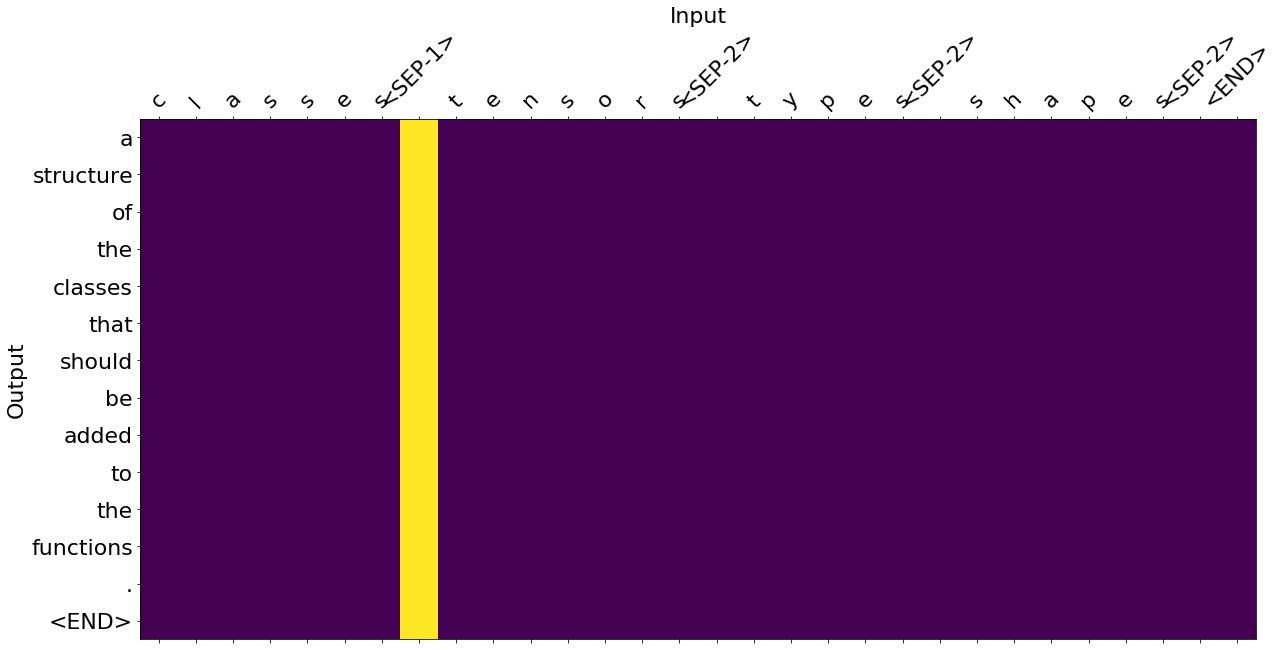

In [52]:

import tensorflow as tf
from matplotlib import pyplot as plt
j = 42
just_one = [ i[j:j+1] for i in data_tuple.test ]
trim = len(np.trim_zeros(just_one[0][0]))


alignments, translate = nn._feed_fwd(sess, just_one, [nn.inf_state.alignment_history.stack(), nn.inference_id] )
char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)
word_output = nn.translate(translate[0], do_join=False)


moved = np.squeeze(alignments)
print(moved.shape)
moved = np.stack([i[:trim] for i in moved])


fig, ax = plt.subplots(figsize=(20,20))
# plt.rcParams['figure.figsize'] = (10,10)
# plt.rcParams.update({'font.size': 22})
ax.matshow(moved)
plt.xticks(np.arange(len(char_input)), char_input, rotation=45)
plt.yticks(np.arange(len(word_output)), word_output)
plt.ylabel("Output")
plt.xlabel("Input")
# ax.xaxis.label.set_fontsize(20)
ax.xaxis.set_label_position('top') 
print(moved.shape)
plt.show()


In [ ]:
# 10, 12, 23, 83, 192, 213, 237, 240, 247, 263, 
for i, t in enumerate(good_examples):
    print(i,t)

In [ ]:
char_embeddings = nn.get_scope_variable(sess, 'embed_vars', 'char_embed')

In [ ]:
len(data_tuple.test[-1])


In [ ]:
#"\n".join("\t".join([str(j) for j in i]) for i in char_embeddings[0]) 
print("\n".join(["Char"] + [nn.idx2char[i] for i in sorted(nn.idx2char.keys())]))
